In [1]:
# A pipeline to walk through stuff 
from alphazero.games.othello import OthelloBoard, OthelloNet
from alphazero.players import AlphaZeroPlayer, MCTSPlayer

board_size = 8 
board = OthelloBoard(n=board_size)

/Users/ayushjain/Development/Research/alphazero/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the othello games

In [2]:
import numpy as np
from src.datasets.datasets import load_kaggle_othello_games

cfg = {
    'board_size': 8,
    'n_positions': 100,      # ~100 games × ~80 moves; loader caps at this
    'min_move_number': 15,     # skip opening
    'max_move_number': 45,    # include late game (standard Othello ~60 moves)
    'seed': 42,
}

positions = load_kaggle_othello_games(cfg)
print(f"Loaded {len(positions)} positions")

Loading Kaggle Othello dataset...
Loaded 25657 games from Kaggle

Collection statistics:
  Total games processed: 4
  Successful parses: 4 (100.0%)
  No positions in range [15,45]: 0
  Parse failures: 0
  Too short: 0
  Total positions collected: 124
Loaded 100 positions


/Users/ayushjain/Development/Research/alphazero/viz_board.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((c, r), 0.38, color='white', edgecolor='black',


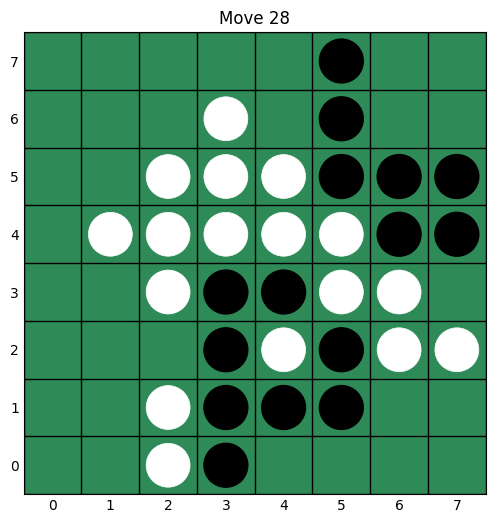

In [3]:
# need to init the board 
# DONT CHANGE ANYTHING --- why did it take hours to get to this point 
board.grid = positions[0]['grid'].copy()
board.player = positions[0]['player']

from viz_board import viz_board
viz_board(board.grid, title=f"Move {positions[0]['move_number']}")

# Load in both models

In [4]:
import torch 
import json 

cfg_path = 'models/alphazero-othello-8/config.json'
checkpoint_path = 'models/alphazero-othello-8/checkpoints/alphazero-othello-8-chkpt-5.pt'
with open(cfg_path, "r") as f:
    json_config = json.load(f)
model_config = OthelloNet.CONFIG(**json_config) # fetch the right Config subclass and init with the json_dict
weak_net = OthelloNet(config=model_config) # init the model with the config
weak_net.load_state_dict(torch.load(checkpoint_path)) # load the weights
weak_net.eval()
weak_player = AlphaZeroPlayer(nn=weak_net, n_sim=100)

In [5]:
name = 'alphazero-othello-8'
checkpoint = 'models/'
strong_net = OthelloNet.from_pretrained(name, checkpoint)
strong_net.eval()
strong_player = AlphaZeroPlayer(nn=strong_net, n_sim=100)

In [6]:
from tqdm import tqdm
# Disagreement filter -- find positions where the models disagree 
board.grid = positions[0]['grid'].copy()
board.player = positions[0]['player']

interesting_positions = []

for pos in tqdm(positions, desc="Processing positions"): 
    board.grid = pos['grid'].copy()
    board.player = pos['player']
    
    #compare the two moves 
    strong_player.reset()
    strong_move, _, _, _ = strong_player.get_move(board)

    weak_player.reset()
    weak_move, _, _, _ = weak_player.get_move(board)

    if weak_move != strong_move: 
        interesting_positions.append(pos)

print(len(interesting_positions), len(positions))
print(len(interesting_positions) / len(positions))

Processing positions: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

61 100
0.61


In [7]:
weak_player = AlphaZeroPlayer(nn=weak_net, n_sim=1000)
strong_player = AlphaZeroPlayer(nn=strong_net, n_sim=1000)

In [8]:
from tqdm import tqdm
# Disagreement filter -- find positions where the models disagree 

filtered_positions = []

for pos in tqdm(interesting_positions, desc="Processing positions"): 
    board.grid = pos['grid'].copy()
    board.player = pos['player']
    
    #compare the two moves 
    strong_player.reset()
    strong_move, _, _, _ = strong_player.get_move(board)

    weak_player.reset()
    weak_move, _, _, _ = weak_player.get_move(board)

    if weak_move != strong_move: 
        filtered_positions.append(pos)

print(len(filtered_positions), len(interesting_positions))
print(len(filtered_positions) / len(interesting_positions))

Processing positions: 100%|██████████| 61/61 [02:50<00:00,  2.79s/it]

41 61
0.6721311475409836


In [ ]:
# filtration done. now get all the concept vectors for this. 